# Whole Slide Image Registration

Click to open in: \[[GitHub](https://github.com/ruqayya/Whole-Slide-Image-Registration/blob/main/WSI_Registration.ipynb)\]\[[Colab](https://colab.research.google.com/github/ruqayya/Whole-Slide-Image-Registration/blob/main/WSI_Registration.ipynb)\]



## About this notebook

This Jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



### About this demo

In this example, we will show how to use TIAToolbox for registration of an image pair using [Deep Feature Based Registration](https://arxiv.org/pdf/2202.09971.pdf) (DFBR) \[1\], followed by non-rigid alignment using [SimpleITK](https://simpleitk.readthedocs.io/en/master/registrationOverview.html). The registration tool in the TIAToolbox also comprises a pre-alignment step, pre-requisite to DFBR. In particular, we will introduce the use of our registration tool `wsi_registration`.

\[1\] Awan, Ruqayya, et al. "Deep Feature based Cross-slide Registration." arXiv preprint arXiv:2202.09971 (2022).



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@DFBR_notenook_revised | tail --line 1

print("Installation is done.")

**IMPORTANT**: When you run the cell above for the first time, while using Colab, you need to restart the runtime before proceeding further. Click on the box *RESTART RUNTIME* that appears immediately above this cell, or use the menu *Runtime→Restart runtime*. This loads the latest versions of prerequisite packages. The notebook can then be managed normally. For example, you can run subsequent cells one by one, or you can click on *Runtime→Run all* or *Runtime→after*.



### GPU or CPU runtime

Processes in this notebook can be accelerated by using a GPU. Therefore, whether you are running this notebook on your own system or on Colab, you need to check and specify whether you are using GPU or CPU. In Colab, you need to make sure that the runtime type is set to GPU in the *Runtime→Change runtime type→Hardware accelerator*. If you are *not* using GPU, change `ON_GPU` to `False`, otherwise, some errors will be raised when running the following cells.



In [1]:
ON_GPU = True  # Should be changed to False if no cuda-enabled GPU is available

### Clean-up before a run

To ensure proper clean-up (for example in abnormal termination), all files downloaded or created in this run are saved in a single directory global_save_dir, which we set equal to "./tmp/". To simplify maintenance, the name of the directory occurs only at this one place, so that it can easily be changed, if desired.



In [7]:
import warnings
import os
import shutil

warnings.filterwarnings("ignore")
global_save_dir = "./tmp/"


def rmdir(dir_path):
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
        print("removing directory ", dir_path)


rmdir(global_save_dir)  # remove  directory if it exists from previous runs
os.mkdir(global_save_dir)
print("creating new directory ", global_save_dir)

### Importing related libraries

We import some standard Python modules, and also the TIAToolbox Python modules for the image registration task, written by the TIA Centre team.



In [ ]:
from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor
from tiatoolbox.tools.registration.wsi_registration import (
    match_histograms,
    DFBRegister,
    Transformer,
    apply_bspline_transform,
    estimate_bspline_transform,
)
from tiatoolbox.wsicore.wsireader import WSIReader
import os
import cv2
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from skimage import color, exposure, measure, morphology
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

### Downloading the required files

We download, over the internet, image files used for the purpose of this notebook. In particular, we download a sample pair of images from the COMET dataset which is currently a private dataset of TIA centre. Downloading is needed once in each Colab session and it should take less than 2 minutes. Two WSIs are downloaded from the web, as seen in the code below, and saved with filenames given by the variable fixed_img_file_name and moving_img_file_name in the directory given by data_dir. Data generated by the notebook is stored under data_dir, providing rapid local access.



In [4]:
import requests

fixed_img_file_name = "fixed_image.tif"
moving_img_file_name = "moving_image.tif"

# Downloading fixed image from COMET dataset
r = requests.get(
    "https://tiatoolbox.dcs.warwick.ac.uk/testdata/registration/CRC/06-18270_5_A1MLH1_1.tif"
)
with open(fixed_img_file_name, "wb") as f:
    f.write(r.content)

# Downloading moving image from COMET dataset
r = requests.get(
    "https://tiatoolbox.dcs.warwick.ac.uk/testdata/registration/CRC/06-18270_5_A1MSH2_1.tif"
)
with open(moving_img_file_name, "wb") as f:
    f.write(r.content)

### Reading and visualising images

Below, we read a downsampled version of the fixed and moving WSIs using WSIReader. WSIReader shields the user from the incompatible formats produced by different models of scanners from different vendors. The function WSIReader.open has as input a particular WSI, with a particular image format, and outputs an object fixed_wsi_reader, whose base class is WSIReader, and whose derived class depends on the image format. We load fixed and moving WSIs specified with the help of their corresponding path variables fixed_img_file_name and moving_img_file_name, respectively.



In [ ]:
fixed_wsi_reader = WSIReader.open(input_img=fixed_img_file_name)
fixed_image_rgb = fixed_wsi_reader.slide_thumbnail(resolution=0.1563, units="power")
moving_wsi_reader = WSIReader.open(input_img=moving_img_file_name)
moving_image_rgb = moving_wsi_reader.slide_thumbnail(resolution=0.1563, units="power")

_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_image_rgb, cmap="gray")
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image_rgb, cmap="gray")
axs[1].set_title("Moving Image")
plt.show()

### Image Pre-processing

The images are converted to greyscale. The contrast of both the images is improved by linearly rescaling the values. To unify the appearance of an image pair, histogram matching is performed as a normalisation step. In histogram matching, the histogram of an image is modified to be similar to that of another image. An image with high entropy is considered as a reference image and the histogram of an image with low entropy is matched to the reference image.



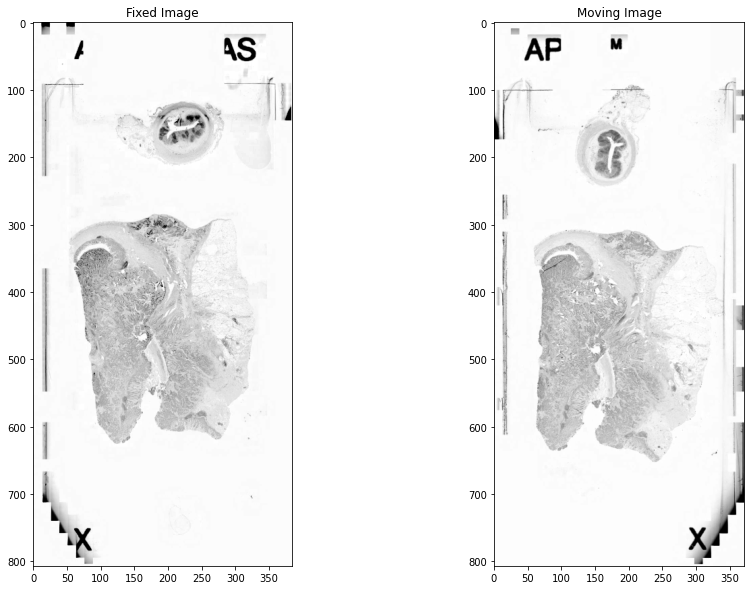

In [13]:
def preprocess_image(image):
    image = color.rgb2gray(image)
    image = exposure.rescale_intensity(
        image, in_range=tuple(np.percentile(image, (0.5, 99.5)))
    )
    image = image * 255
    return image.astype(np.uint8)


fixed_image = preprocess_image(fixed_image_rgb)
moving_image = preprocess_image(moving_image_rgb)
fixed_image, moving_image = match_histograms(fixed_image, moving_image)

_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_image, cmap="gray")
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap="gray")
axs[1].set_title("Moving Image")
plt.show()

temp = np.repeat(np.expand_dims(fixed_image, axis=2), 3, axis=2)
_isWritten = cv2.imwrite(os.path.join(global_save_dir, "fixed.png"), temp)
temp = np.repeat(np.expand_dims(moving_image, axis=2), 3, axis=2)
_isWritten = cv2.imwrite(os.path.join(global_save_dir, "moving.png"), temp)

### Tissue Segmentation

In this section, image segmentation is performed to generate tissue masks so that registration can be performed using only the active or discriminatory tissue area. In DFBR, these are used to exclude the matching points from the non-tissue and fatty regions while in the non-rigid alignment method, the background region is excluded from images before inputting them to the SimpleITK module.

We should mention that when you use a TIAToolbox pretrained model, you don't need to worry about setting the input/output shape parameters as their optimal values will be loaded by default.



In [ ]:
save_dir = os.path.join(global_save_dir, "tissue_mask")
if os.path.exists(save_dir):
    shutil.rmtree(save_dir, ignore_errors=False, onerror=None)

segmentor = SemanticSegmentor(
    pretrained_model="unet_tissue_mask_tsef",
    num_loader_workers=4,
    batch_size=4,
)

output = segmentor.predict(
    [
        os.path.join(global_save_dir, "fixed.png"),
        os.path.join(global_save_dir, "moving.png"),
    ],
    save_dir=save_dir,
    mode="tile",
    resolution=1.0,
    units="baseline",
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[512, 512],
    on_gpu=ON_GPU,
    crash_on_exception=True,
)

### Post-processing and Visualization of Masks

In the output, the prediction method returns a list of the paths to its inputs and to the processed outputs saved on the disk. This can be used to load the results for processing and visualisation. In this section, a simple processing of the raw prediction is performed to generate the tissue mask.



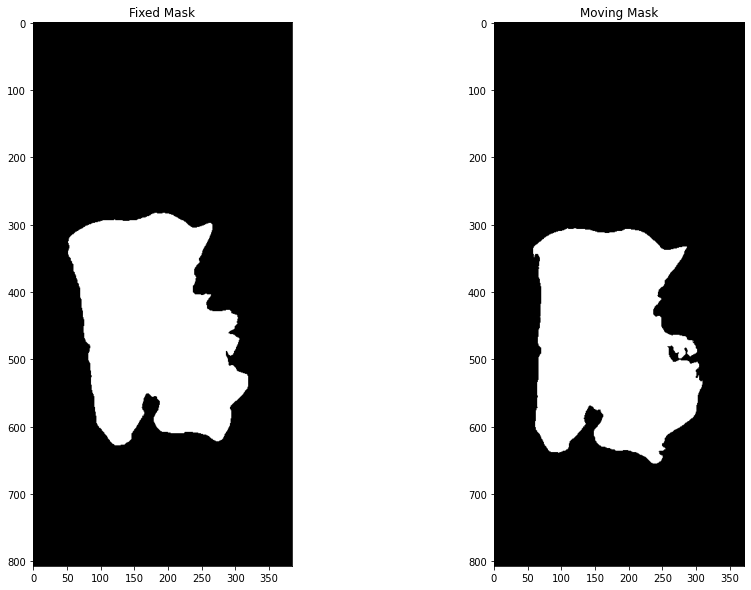

In [15]:
def post_processing_mask(mask):
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((3, 3))).astype(int)

    # remove all the objects while keep the biggest object only
    label_img = measure.label(mask)
    if len(np.unique(label_img)) > 2:
        regions = measure.regionprops(label_img)
        mask = mask.astype(bool)
        all_area = [i.area for i in regions]
        second_max = max([i for i in all_area if i != max(all_area)])
        mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
    return mask.astype(np.uint8)


fixed_mask = np.load(output[0][1] + ".raw.0.npy")
moving_mask = np.load(output[1][1] + ".raw.0.npy")

# Simple processing of the raw prediction to generate semantic segmentation task
fixed_mask = np.argmax(fixed_mask, axis=-1) == 2
moving_mask = np.argmax(moving_mask, axis=-1) == 2

fixed_mask = post_processing_mask(fixed_mask)
moving_mask = post_processing_mask(moving_mask)

_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_mask, cmap="gray")
axs[0].set_title("Fixed Mask")
axs[1].imshow(moving_mask, cmap="gray")
axs[1].set_title("Moving Mask")
plt.show()

### Registration using DFBR

In this section, we apply the DFBR method for aligning the moving image with respect to the fixed image. The pre-trained VGG-16 model is used as a feature extractor which accepts input images with 3 channels. Therefore, greyscale images were stacked as the colour channel. The output of "df.register" is the affine transform which is capable of representing translations, rotations, shearing and scaling.



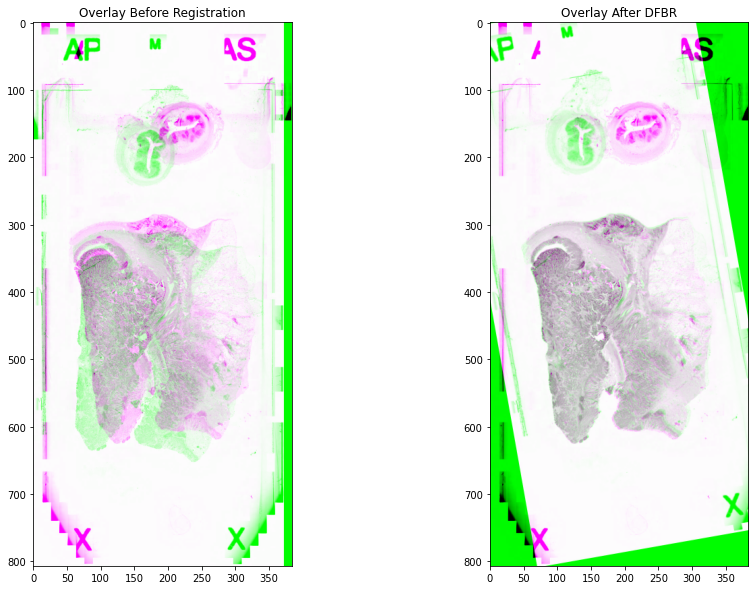

In [16]:
dfbr_fixed_image = np.repeat(np.expand_dims(fixed_image, axis=2), 3, axis=2)
dfbr_moving_image = np.repeat(np.expand_dims(moving_image, axis=2), 3, axis=2)

df = DFBRegister()
dfbr_transform = df.register(
    dfbr_fixed_image, dfbr_moving_image, fixed_mask, moving_mask
)

# Visualization
original_moving = cv2.warpAffine(
    moving_image, np.eye(2, 3), fixed_image.shape[:2][::-1]
)
dfbr_registered_image = cv2.warpAffine(
    moving_image, dfbr_transform[0:-1], fixed_image.shape[:2][::-1]
)
dfbr_registered_mask = cv2.warpAffine(
    moving_mask, dfbr_transform[0:-1], fixed_image.shape[:2][::-1]
)

before_overlay = np.dstack((original_moving, fixed_image, original_moving))
dfbr_overlay = np.dstack((dfbr_registered_image, fixed_image, dfbr_registered_image))

_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(before_overlay, cmap="gray")
axs[0].set_title("Overlay Before Registration")
axs[1].imshow(dfbr_overlay, cmap="gray")
axs[1].set_title("Overlay After DFBR")
plt.show()

### Patch Extraction

In this section, we show how to extract a region from a fixed image and the corresponding region from a moving image of any size at a specific location of any pyramid level. The transformation is applied for the requested tile and there is no need to generate transformed WSI in a pyramidal format.



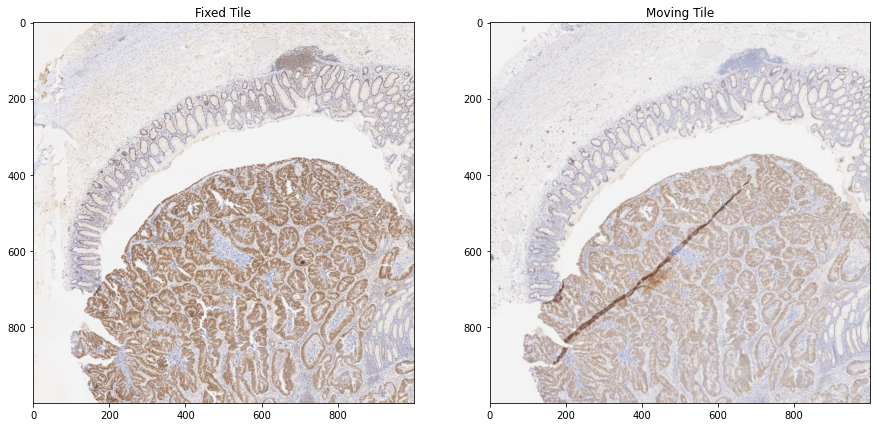

In [17]:
location = (3500, 20000)  # at base level 0
level = 2
size = (1000, 1000)  # (width, height)

# Updating the transform w.r.t level 0
transform_level0 = dfbr_transform * [[1, 1, 2**6], [1, 1, 2**6], [1, 1, 1]]

# Extract region from the fixed whole slide image
fixed_tile = fixed_wsi_reader.read_rect(location, size, resolution=level, units="level")

# Extract transformed region from the moving whole slide image
tfm = Transformer(moving_wsi_reader, transform_level0)
moving_tile = tfm.read_rect(location, size, level)

_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(fixed_tile, cmap="gray")
axs[0].set_title("Fixed Tile")
axs[1].imshow(moving_tile, cmap="gray")
axs[1].set_title("Moving Tile")
plt.show()

### B-Spline Transform

In this section, we perform registration of fixed and moving tiles using a multi-resolution B-Spline method. The moving image here is a registered tile after the application of the DFBR transform, as shown above. For any given image pair, this method is shown to perform better with the inverted intensity values.
The B-Spline approach involves a number of parameters that the user can experiment with. Changing these parameters would result in varying complexity and registration completion times. Feel free to play around with the non-rigid alignment parameters and to experiment with new images.



In [ ]:
fixed_mask = np.ones(shape=fixed_tile.shape, dtype=int)
moving_mask = np.ones(shape=moving_tile.shape, dtype=int)
bspline_transform = estimate_bspline_transform(
    fixed_tile,
    moving_tile,
    fixed_mask,
    moving_mask,
    grid_space=200.0,
    sampling_percent=0.1,
)

### Applying Transform to Moving Tile

To apply the transform, a resampling operation is performed.



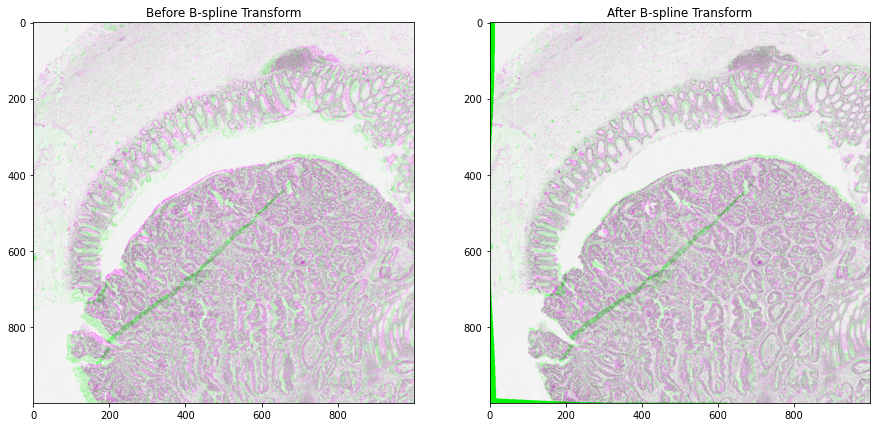

In [19]:
bspline_registered_image = apply_bspline_transform(
    fixed_tile, moving_tile, bspline_transform
)

tile_overlay = np.dstack(
    (moving_tile[:, :, 0], fixed_tile[:, :, 0], moving_tile[:, :, 0])
)
bspline_overlay = np.dstack(
    (
        bspline_registered_image[:, :, 0],
        fixed_tile[:, :, 0],
        bspline_registered_image[:, :, 0],
    )
)

_, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(tile_overlay, cmap="gray")
axs[0].set_title("Before B-spline Transform")
axs[1].imshow(bspline_overlay, cmap="gray")
axs[1].set_title("After B-spline Transform")
plt.show()